# Investigate Vector Search Cutoff

Improve retrieval by limiting returned results based on similarity cutoff instead of a set number.

Run an experiment:
- Pull top N paragraphs for a set of queries.
- Use an LLM to label them as relevant or not.
- Investigate performance metrics (precision and recall) as a function of similarity score.

## Build dataset

### Synthetic data

In [1]:
# use openai llm to generate a set of questions to ask about a world history book
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from pydantic import BaseModel, Field
from typing import List
import os

class HistoryQuestions(BaseModel):
    questions: List[str] = Field(description="List of world history questions")

def generate_history_questions(num_questions=20):
    # Initialize parser and LLM
    parser = JsonOutputParser(pydantic_object=HistoryQuestions)
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.8)
    
    # Create prompt template
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a world history expert who creates thoughtful, educational questions."),
        ("user", """Generate {num_questions} diverse, specific questions that could be asked about a comprehensive world history book. 
    
    The questions should cover:
    - Different time periods (ancient, medieval, modern, contemporary)
    - Various civilizations and regions (Europe, Asia, Africa, Americas, Middle East)
    - Different types of historical topics (political events, cultural developments, economic systems, wars, social movements, technological advances)
    - Both broad conceptual questions and specific factual questions
    
    Make the questions natural and realistic - the kind a student or researcher might ask when studying world history.
    
    Examples of good questions:
    - What were the main causes of World War I?
    - How did the Silk Road impact trade between East and West?
    - What role did the printing press play in the Renaissance?
    
    {format_instructions}""")
    ])
    
    # Create LCEL chain
    chain = prompt | llm | parser
    
    # Execute chain
    result = chain.invoke({
        "num_questions": num_questions,
        "format_instructions": parser.get_format_instructions()
    })
    
    return result


In [2]:

# Generate questions
questions_data = generate_history_questions()
questions_list = questions_data['questions']

print(f"Generated {len(questions_list)} questions:\n")
for i, question in enumerate(questions_list, 1):
    print(f"{i}. {question}")

Generated 20 questions:

1. What were the key factors that led to the fall of the Western Roman Empire?
2. How did the spread of Islam in the 7th century influence trade and cultural exchanges across Africa and Europe?
3. What were the primary motivations behind the European Age of Exploration during the 15th and 16th centuries?
4. In what ways did the Renaissance challenge the traditional views of the medieval Church?
5. How did the Industrial Revolution transform economic systems in Europe and North America?
6. What social movements emerged in the United States during the 19th century, and what impact did they have on American society?
7. How did the Opium Wars between Britain and China alter the course of modern Chinese history?
8. What were the consequences of the Treaty of Versailles on post-World War I Europe?
9. How did the invention of the telephone in the late 19th century affect global communication?
10. What role did women play in the suffrage movement in the early 20th cent

### User queries

In [171]:
from history_book.database.config import WeaviateConfig
from history_book.database.repositories import BookRepositoryManager

In [ ]:
config = WeaviateConfig.from_environment()
repo_manager = BookRepositoryManager(config)

In [179]:
all_messages = repo_manager.chat_messages.list_all()

In [189]:
user_messages = [msg.content for msg in all_messages if msg.role == 'user']
user_messages = list(set(user_messages)) # unique user messages

In [191]:
# manually filter
user_messages = [
    'What were the first civilizations?',
    'when did julius cesar rule?',
    'how does the author define barbarians?',
    'why are Sunnis and Shia called that?',
    'who were the guptas?',
    'name the Chinese dynasties',
    'what was hellenization?',
    'Can you tell me about groups that moved into europe during the roman empire?',
    'Who were the Magyars?',
    'who were the scythians?',
    "what does 'doge' mean?",
    'tell me about the antonine age in rome',
    'Tell me about the Roman Empire',
    'who were the Seljuks?',
    'What groups had interactions with the Magyars?',
    'What were the main causes of World War I?',
]

## Retrieve top results for each query

In [172]:

import pandas as pd
import matplotlib.pyplot as plt

In [195]:
retrieved_para_dict_list = []
for query in questions_data['questions']:
    retrieved_paras = repo_manager.paragraphs.similarity_search_by_text(query, limit=100)
    for para, score in retrieved_paras:
        retrieved_para_dict_list.append({"query": query, "text": para.text, "score": score})


In [196]:
df_retrieved = pd.DataFrame(retrieved_para_dict_list)

(array([ 39.,  20.,  76.,  63.,  43.,  17.,   8.,   8.,  52., 102., 111.,
        202., 167., 192., 174., 169., 129., 101.,  84.,  69.,  52.,  34.,
         28.,  23.,  14.,  11.,   4.,   4.,   2.,   2.]),
 array([0.25718033, 0.2713452 , 0.28551006, 0.29967493, 0.31383979,
        0.32800466, 0.34216952, 0.35633439, 0.37049925, 0.38466412,
        0.39882898, 0.41299385, 0.42715871, 0.44132358, 0.45548844,
        0.46965331, 0.48381817, 0.49798304, 0.5121479 , 0.52631277,
        0.54047763, 0.5546425 , 0.56880736, 0.58297223, 0.59713709,
        0.61130196, 0.62546682, 0.63963169, 0.65379655, 0.66796142,
        0.68212628]),
 <BarContainer object of 30 artists>)

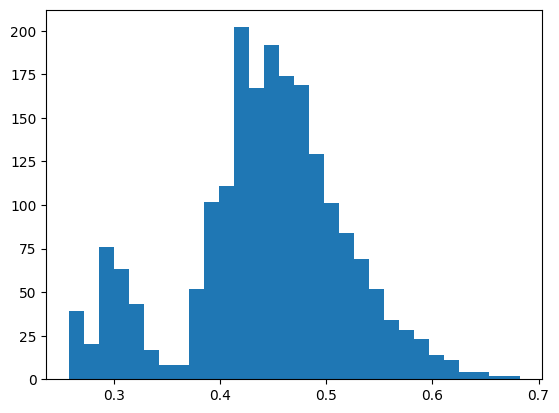

In [197]:
plt.hist(df_retrieved['score'], bins=30)

In [198]:
retrieved_para_dict_list_user = []
for query in user_messages:
    retrieved_paras = repo_manager.paragraphs.similarity_search_by_text(query, limit=100)
    for para, score in retrieved_paras:
        retrieved_para_dict_list_user.append({"query": query, "text": para.text, "score": score})


In [199]:
df_retrieved_user = pd.DataFrame(retrieved_para_dict_list_user)

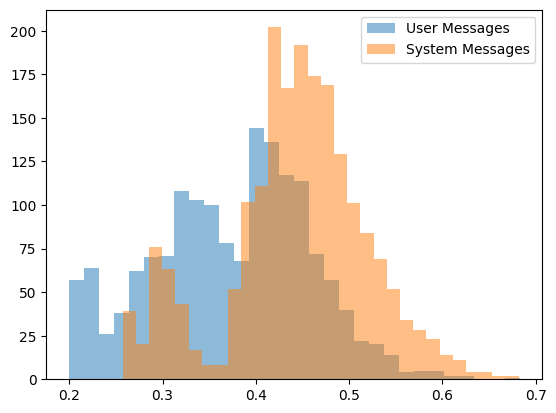

In [200]:
plt.hist(df_retrieved_user['score'], bins=30, alpha=0.5, label='User Messages')
plt.hist(df_retrieved['score'], bins=30, alpha=0.5, label='System Messages')
plt.legend()
plt.show()

## Set up evals: use LLM to determine whether retrieved paragraphs are relevant to query

In [36]:
from pydantic import BaseModel, Field
import asyncio
from tqdm.asyncio import tqdm

In [23]:

class RelevanceEvaluation(BaseModel):
    is_relevant: bool = Field(description="Whether the paragraph is relevant to answering the query")
    reasoning: str = Field(description="Brief explanation of the relevance decision")

In [26]:

retrieval_relevance_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are an expert evaluator determining whether a text paragraph is relevant to answering a specific query about world history.

A paragraph is RELEVANT if:
- It directly answers the question or provides information needed to answer it
- It contains key facts, concepts, or context related to the query
- It discusses the same historical period, event, person, or concept mentioned in the query

A paragraph is NOT RELEVANT if:
- It discusses completely unrelated topics, time periods, or regions
- It only mentions the topic tangentially without providing useful information
- It cannot help answer the query in any meaningful way

Be strict but fair in your evaluation."""
    ),
    (
        "user", 
        """Query: {query}

Paragraph: {paragraph}

Evaluate whether this paragraph is relevant to answering the query.

{format_instructions}"""
    )
])
    

In [33]:

async def evaluate_relevance(query: str, paragraph: str) -> dict:
    """Evaluate whether a paragraph is relevant to answering a query"""
    parser = JsonOutputParser(pydantic_object=RelevanceEvaluation)
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)  # Low temp for consistent evaluations
    
    chain = retrieval_relevance_prompt | llm | parser

    result = await chain.ainvoke({
        "query": query,
        "paragraph": paragraph,
        "format_instructions": parser.get_format_instructions()
    })
    
    return result


In [34]:

# Test the evaluation function
test_query = questions_data['questions'][0]
test_paragraph = df_retrieved[df_retrieved['query'] == test_query]['text'].iloc[0]


In [35]:

print(f"Query: {test_query}")
print(f"\nParagraph: {test_paragraph}...")
print(f"\nEvaluation: {await evaluate_relevance(test_query, test_paragraph)}")

Query: What were the key factors that led to the fall of the Western Roman Empire?

Paragraph: One explanation is cumulative: the state apparatus in the West gradually seized up after the recovery of the fourth century. The whole concern became too big for the demographic, fiscal and economic base which carried it. The main purpose of raising revenue was to pay for the military machine, but it became more and more difficult to raise enough. There were no more conquests after Dacia to bring in new tribute. Soon the measures adopted to squeeze out more taxes drove rich and poor alike to devices for avoiding them. The effect was to make agricultural estates rely more and more upon meeting their own needs and to become self- supporting, rather than producing for the market. Parallel with this went a crumbling of urban government as trade languished and the rich withdrew to the countryside....

Evaluation: {'is_relevant': True, 'reasoning': "The paragraph discusses key factors that contribu

In [41]:
from openai import RateLimitError

In [43]:
async def evaluate_relevance_with_retry(query: str, paragraph: str, max_retries=5) -> dict:
    """Evaluate relevance with exponential backoff for rate limits"""
    parser = JsonOutputParser(pydantic_object=RelevanceEvaluation)
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)
    chain = retrieval_relevance_prompt | llm | parser
    
    for attempt in range(max_retries):
        try:
            result = await chain.ainvoke({
                "query": query,
                "paragraph": paragraph,
                "format_instructions": parser.get_format_instructions()
            })
            return result
        except RateLimitError as e:
            if attempt < max_retries - 1:
                # Exponential backoff: 2^attempt seconds
                wait_time = 2 ** attempt
                print(f"Rate limit hit, waiting {wait_time} seconds before retry {attempt + 1}")
                await asyncio.sleep(wait_time)
            else:
                raise e
        except Exception as e:
            print(f"Unexpected error: {e}")
            if attempt < max_retries - 1:
                await asyncio.sleep(1)
            else:
                raise e

In [44]:

async def evaluate_all_relevance(df, batch_size=50):  # Reduced batch size
    """Evaluate relevance for all rows in the dataframe using batching with rate limit handling"""
    all_results = []
    
    # Process in batches
    for i in range(0, len(df), batch_size):
        batch_df = df.iloc[i:i+batch_size]
        
        # Create tasks for this batch
        tasks = []
        for _, row in batch_df.iterrows():
            task = evaluate_relevance_with_retry(row['query'], row['text'])
            tasks.append(task)
        
        # Run batch concurrently with progress bar
        batch_results = await tqdm.gather(*tasks, desc=f"Evaluating batch {i//batch_size + 1}")
        all_results.extend(batch_results)
        
        # Longer delay between batches to avoid rate limits
        print(f"Completed batch {i//batch_size + 1}, waiting 5 seconds...")
        await asyncio.sleep(5)
    
    # Add results back to dataframe
    df_copy = df.copy()
    for i, result in enumerate(all_results):
        df_copy.loc[df_copy.index[i], 'is_relevant'] = result['is_relevant']
        df_copy.loc[df_copy.index[i], 'reasoning'] = result['reasoning']
    
    return df_copy

In [45]:
# Run the parallel evaluation with batching
df_with_evals = await evaluate_all_relevance(df_retrieved)

Evaluating batch 1: 100%|██████████| 50/50 [00:02<00:00, 16.81it/s]



Completed batch 1, waiting 5 seconds...


Evaluating batch 2: 100%|██████████| 50/50 [00:03<00:00, 14.76it/s]



Completed batch 2, waiting 5 seconds...


Evaluating batch 3: 100%|██████████| 50/50 [00:02<00:00, 19.38it/s]



Completed batch 3, waiting 5 seconds...


Evaluating batch 4: 100%|██████████| 50/50 [00:03<00:00, 14.39it/s]



Completed batch 4, waiting 5 seconds...


Evaluating batch 5: 100%|██████████| 50/50 [00:02<00:00, 21.34it/s]



Completed batch 5, waiting 5 seconds...


Evaluating batch 6: 100%|██████████| 50/50 [00:02<00:00, 16.80it/s]



Completed batch 6, waiting 5 seconds...


Evaluating batch 7: 100%|██████████| 50/50 [00:02<00:00, 17.98it/s]



Completed batch 7, waiting 5 seconds...


Evaluating batch 8: 100%|██████████| 50/50 [00:02<00:00, 18.31it/s]



Completed batch 8, waiting 5 seconds...


Evaluating batch 9: 100%|██████████| 50/50 [00:03<00:00, 16.08it/s]



Completed batch 9, waiting 5 seconds...


Evaluating batch 10: 100%|██████████| 50/50 [00:03<00:00, 15.78it/s]



Completed batch 10, waiting 5 seconds...


Evaluating batch 11: 100%|██████████| 50/50 [00:03<00:00, 16.38it/s]



Completed batch 11, waiting 5 seconds...


Evaluating batch 12: 100%|██████████| 50/50 [00:02<00:00, 21.69it/s]



Completed batch 12, waiting 5 seconds...


Evaluating batch 13: 100%|██████████| 50/50 [00:02<00:00, 22.66it/s]



Completed batch 13, waiting 5 seconds...


Evaluating batch 14: 100%|██████████| 50/50 [00:02<00:00, 20.28it/s]



Completed batch 14, waiting 5 seconds...


Evaluating batch 15: 100%|██████████| 50/50 [00:02<00:00, 19.99it/s]



Completed batch 15, waiting 5 seconds...


Evaluating batch 16: 100%|██████████| 50/50 [00:03<00:00, 13.52it/s]



Completed batch 16, waiting 5 seconds...


Evaluating batch 17: 100%|██████████| 50/50 [00:02<00:00, 19.78it/s]



Completed batch 17, waiting 5 seconds...


Evaluating batch 18: 100%|██████████| 50/50 [00:03<00:00, 15.13it/s]



Completed batch 18, waiting 5 seconds...


Evaluating batch 19: 100%|██████████| 50/50 [00:02<00:00, 19.23it/s]



Completed batch 19, waiting 5 seconds...


Evaluating batch 20: 100%|██████████| 50/50 [00:02<00:00, 16.94it/s]



Completed batch 20, waiting 5 seconds...


Evaluating batch 21: 100%|██████████| 50/50 [00:03<00:00, 15.87it/s]



Completed batch 21, waiting 5 seconds...


Evaluating batch 22: 100%|██████████| 50/50 [00:03<00:00, 15.11it/s]



Completed batch 22, waiting 5 seconds...


Evaluating batch 23: 100%|██████████| 50/50 [00:03<00:00, 13.92it/s]



Completed batch 23, waiting 5 seconds...


Evaluating batch 24: 100%|██████████| 50/50 [00:03<00:00, 15.75it/s]



Completed batch 24, waiting 5 seconds...


Evaluating batch 25: 100%|██████████| 50/50 [00:02<00:00, 21.34it/s]



Completed batch 25, waiting 5 seconds...


Evaluating batch 26: 100%|██████████| 50/50 [00:02<00:00, 23.10it/s]



Completed batch 26, waiting 5 seconds...


Evaluating batch 27: 100%|██████████| 50/50 [00:02<00:00, 19.79it/s]



Completed batch 27, waiting 5 seconds...


Evaluating batch 28: 100%|██████████| 50/50 [00:02<00:00, 19.44it/s]



Completed batch 28, waiting 5 seconds...


Evaluating batch 29: 100%|██████████| 50/50 [00:02<00:00, 21.78it/s]



Completed batch 29, waiting 5 seconds...


Evaluating batch 30: 100%|██████████| 50/50 [00:03<00:00, 15.05it/s]



Completed batch 30, waiting 5 seconds...


Evaluating batch 31: 100%|██████████| 50/50 [00:02<00:00, 18.88it/s]



Completed batch 31, waiting 5 seconds...


Evaluating batch 32: 100%|██████████| 50/50 [00:02<00:00, 23.03it/s]



Completed batch 32, waiting 5 seconds...


Evaluating batch 33: 100%|██████████| 50/50 [00:03<00:00, 14.11it/s]



Completed batch 33, waiting 5 seconds...


Evaluating batch 34: 100%|██████████| 50/50 [00:02<00:00, 24.31it/s]



Completed batch 34, waiting 5 seconds...


Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, wait

Evaluating batch 35:   2%|▏         | 1/50 [00:01<01:02,  1.27s/it]

Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1


Evaluating batch 35:  20%|██        | 10/50 [00:01<00:03, 10.60it/s]

Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, wait

Evaluating batch 35:  52%|█████▏    | 26/50 [00:06<00:08,  2.81it/s]

Rate limit hit, waiting 4 seconds before retry 3


Evaluating batch 35: 100%|██████████| 50/50 [00:12<00:00,  4.11it/s]



Completed batch 35, waiting 5 seconds...


Evaluating batch 36: 100%|██████████| 50/50 [00:02<00:00, 24.99it/s]


Completed batch 36, waiting 5 seconds...


Evaluating batch 37: 100%|██████████| 50/50 [00:03<00:00, 16.47it/s]



Completed batch 37, waiting 5 seconds...


Evaluating batch 38: 100%|██████████| 50/50 [00:02<00:00, 17.14it/s]



Completed batch 38, waiting 5 seconds...


Evaluating batch 39:   0%|          | 0/50 [00:00<?, ?it/s]

Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1
Rate limit hit, waiting 1 seconds before retry 1


Evaluating batch 39:   2%|▏         | 1/50 [00:01<01:08,  1.40s/it]

Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 2 seconds before retry 2
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, waiting 4 seconds before retry 3
Rate limit hit, wait

Evaluating batch 39: 100%|██████████| 50/50 [00:11<00:00,  4.23it/s]



Completed batch 39, waiting 5 seconds...


Evaluating batch 40: 100%|██████████| 50/50 [00:02<00:00, 23.14it/s]



Completed batch 40, waiting 5 seconds...


In [46]:
df_with_evals

,query,text,score,is_relevant,reasoning
0,What were the key factors that led to the fall...,One explanation is cumulative: the state appar...,0.632161,True,The paragraph discusses key factors that contr...
1,What were the key factors that led to the fall...,"Socially and economically, the tale of the thi...",0.624099,True,The paragraph discusses key factors that contr...
2,What were the key factors that led to the fall...,"This is striking: what, actually, had collapse...",0.593135,True,The paragraph discusses the collapse of the st...
3,What were the key factors that led to the fall...,The ups and downs of imperial authority matter...,0.590381,True,The paragraph discusses the weaknesses in the ...
4,What were the key factors that led to the fall...,This was in more than one way a turning-point....,0.573790,True,The paragraph discusses key events and factors...
...,...,...,...,...,...
1995,What impact did the internet have on global cu...,Some assembly lines nowadays are ‘manned’ enti...,0.409506,False,The paragraph discusses technological changes ...
1996,What impact did the internet have on global cu...,"Such changes are not easily dated, because acc...",0.409291,False,The paragraph discusses the impact of the prin...
1997,What impact did the internet have on global cu...,One change is quickly apparent: in different p...,0.409188,False,The paragraph discusses the differentiation of...
1998,What impact did the internet have on global cu...,This not only brought African-Americans into v...,0.409149,False,The paragraph discusses the struggles and achi...


In [51]:
# save to csv
df_with_evals.to_csv("retrieval_relevance_evaluations.csv", index=False)

In [201]:
# Run the parallel evaluation with batching
df_with_evals_user = await evaluate_all_relevance(df_retrieved_user)

Evaluating batch 1: 100%|██████████| 50/50 [00:04<00:00, 12.33it/s]


Completed batch 1, waiting 5 seconds...


Evaluating batch 2: 100%|██████████| 50/50 [00:04<00:00, 10.06it/s]


Completed batch 2, waiting 5 seconds...


Evaluating batch 3: 100%|██████████| 50/50 [00:03<00:00, 15.36it/s]


Completed batch 3, waiting 5 seconds...


Evaluating batch 4: 100%|██████████| 50/50 [00:04<00:00, 11.07it/s]


Completed batch 4, waiting 5 seconds...


Evaluating batch 5: 100%|██████████| 50/50 [00:04<00:00, 11.37it/s]


Completed batch 5, waiting 5 seconds...


Evaluating batch 6: 100%|██████████| 50/50 [00:05<00:00,  9.88it/s]


Completed batch 6, waiting 5 seconds...


Evaluating batch 7: 100%|██████████| 50/50 [00:04<00:00, 11.33it/s]


Completed batch 7, waiting 5 seconds...


Evaluating batch 8: 100%|██████████| 50/50 [00:05<00:00,  8.89it/s]


Completed batch 8, waiting 5 seconds...


Evaluating batch 9: 100%|██████████| 50/50 [00:03<00:00, 13.75it/s]


Completed batch 9, waiting 5 seconds...


Evaluating batch 10: 100%|██████████| 50/50 [00:09<00:00,  5.29it/s]


Completed batch 10, waiting 5 seconds...


Evaluating batch 11: 100%|██████████| 50/50 [00:03<00:00, 16.26it/s]


Completed batch 11, waiting 5 seconds...


Evaluating batch 12: 100%|██████████| 50/50 [00:04<00:00, 11.68it/s]


Completed batch 12, waiting 5 seconds...


Evaluating batch 13: 100%|██████████| 50/50 [00:03<00:00, 15.61it/s]


Completed batch 13, waiting 5 seconds...


Evaluating batch 14: 100%|██████████| 50/50 [00:03<00:00, 14.77it/s]


Completed batch 14, waiting 5 seconds...


Evaluating batch 15: 100%|██████████| 50/50 [00:15<00:00,  3.17it/s]


Completed batch 15, waiting 5 seconds...


Evaluating batch 16: 100%|██████████| 50/50 [00:09<00:00,  5.33it/s]


Completed batch 16, waiting 5 seconds...


Evaluating batch 17: 100%|██████████| 50/50 [00:03<00:00, 15.48it/s]


Completed batch 17, waiting 5 seconds...


Evaluating batch 18: 100%|██████████| 50/50 [00:02<00:00, 18.22it/s]


Completed batch 18, waiting 5 seconds...


Evaluating batch 19: 100%|██████████| 50/50 [00:03<00:00, 15.64it/s]


Completed batch 19, waiting 5 seconds...


Evaluating batch 20: 100%|██████████| 50/50 [00:11<00:00,  4.22it/s]


Completed batch 20, waiting 5 seconds...


Evaluating batch 21: 100%|██████████| 50/50 [00:02<00:00, 20.05it/s]


Completed batch 21, waiting 5 seconds...


Evaluating batch 22: 100%|██████████| 50/50 [00:02<00:00, 19.54it/s]


Completed batch 22, waiting 5 seconds...


Evaluating batch 23: 100%|██████████| 50/50 [00:03<00:00, 13.75it/s]


Completed batch 23, waiting 5 seconds...


Evaluating batch 24: 100%|██████████| 50/50 [00:04<00:00, 11.12it/s]


Completed batch 24, waiting 5 seconds...


Evaluating batch 25: 100%|██████████| 50/50 [00:02<00:00, 17.68it/s]


Completed batch 25, waiting 5 seconds...


Evaluating batch 26: 100%|██████████| 50/50 [00:03<00:00, 14.81it/s]


Completed batch 26, waiting 5 seconds...


Evaluating batch 27: 100%|██████████| 50/50 [00:02<00:00, 18.70it/s]


Completed batch 27, waiting 5 seconds...


Evaluating batch 28: 100%|██████████| 50/50 [00:06<00:00,  8.15it/s]


Completed batch 28, waiting 5 seconds...


Evaluating batch 29: 100%|██████████| 50/50 [00:03<00:00, 15.34it/s]


Completed batch 29, waiting 5 seconds...


Evaluating batch 30: 100%|██████████| 50/50 [00:03<00:00, 15.81it/s]


Completed batch 30, waiting 5 seconds...


Evaluating batch 31: 100%|██████████| 50/50 [00:04<00:00, 11.65it/s]


Completed batch 31, waiting 5 seconds...


Evaluating batch 32: 100%|██████████| 50/50 [00:03<00:00, 15.65it/s]


Completed batch 32, waiting 5 seconds...


In [202]:
df_with_evals_user

,query,text,score,is_relevant,reasoning
0,What were the first civilizations?,Somewhere in the fourth millennium BC is the s...,0.620501,True,The paragraph provides a chronological overvie...
1,What were the first civilizations?,About these first civilizations (whose appeara...,0.594695,True,The paragraph discusses the characteristics an...
2,What were the first civilizations?,Mesopotamia was not the only great river valle...,0.593171,True,"The paragraph discusses Mesopotamia and Egypt,..."
3,What were the first civilizations?,Some of these early civilizations are still re...,0.590554,True,The paragraph discusses early civilizations an...
4,What were the first civilizations?,The best case for the first appearance of some...,0.587494,True,The paragraph discusses the emergence of civil...
...,...,...,...,...,...
1595,What were the main causes of World War I?,The feeling that Great Britain and France had ...,0.397652,False,The paragraph discusses European imperialism a...
1596,What were the main causes of World War I?,Yet collapse followed. Economic recovery had b...,0.396742,False,The paragraph discusses economic recovery and ...
1597,What were the main causes of World War I?,The demonstration that the European age was at...,0.396399,False,The paragraph discusses World War II and its c...
1598,What were the main causes of World War I?,When a few Japanese bombs had even fallen on t...,0.395359,False,The paragraph discusses events related to Worl...


In [203]:
# save to csv
df_with_evals_user.to_csv("retrieval_relevance_evaluations_user_queries.csv", index=False)

## Analyze eval results

In [52]:
import numpy as np
from history_book.utils import print_with_wrapping

### Synthetic queries

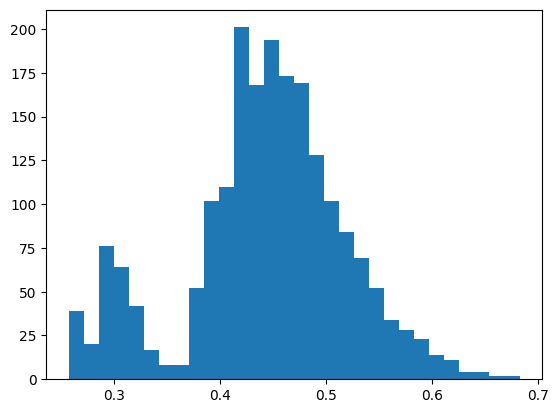

In [49]:
plt.hist(df_with_evals['score'], bins=30)
plt.show()

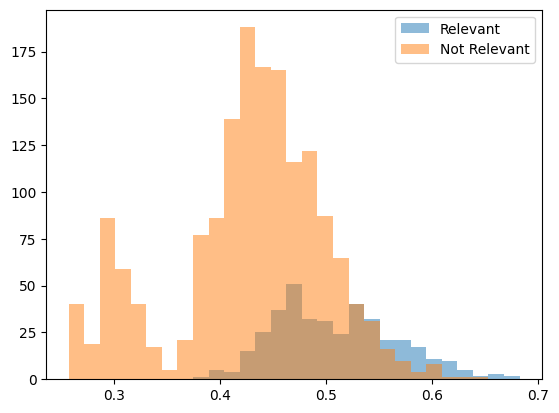

In [53]:
score_min = df_with_evals['score'].min()
score_max = df_with_evals['score'].max()
plt.hist(df_with_evals[df_with_evals['is_relevant'] == True]['score'], bins=np.linspace(score_min, score_max, 30), alpha=0.5, label='Relevant')
plt.hist(df_with_evals[df_with_evals['is_relevant'] == False]['score'], bins=np.linspace(score_min, score_max, 30), alpha=0.5, label='Not Relevant')
plt.legend()
plt.show()

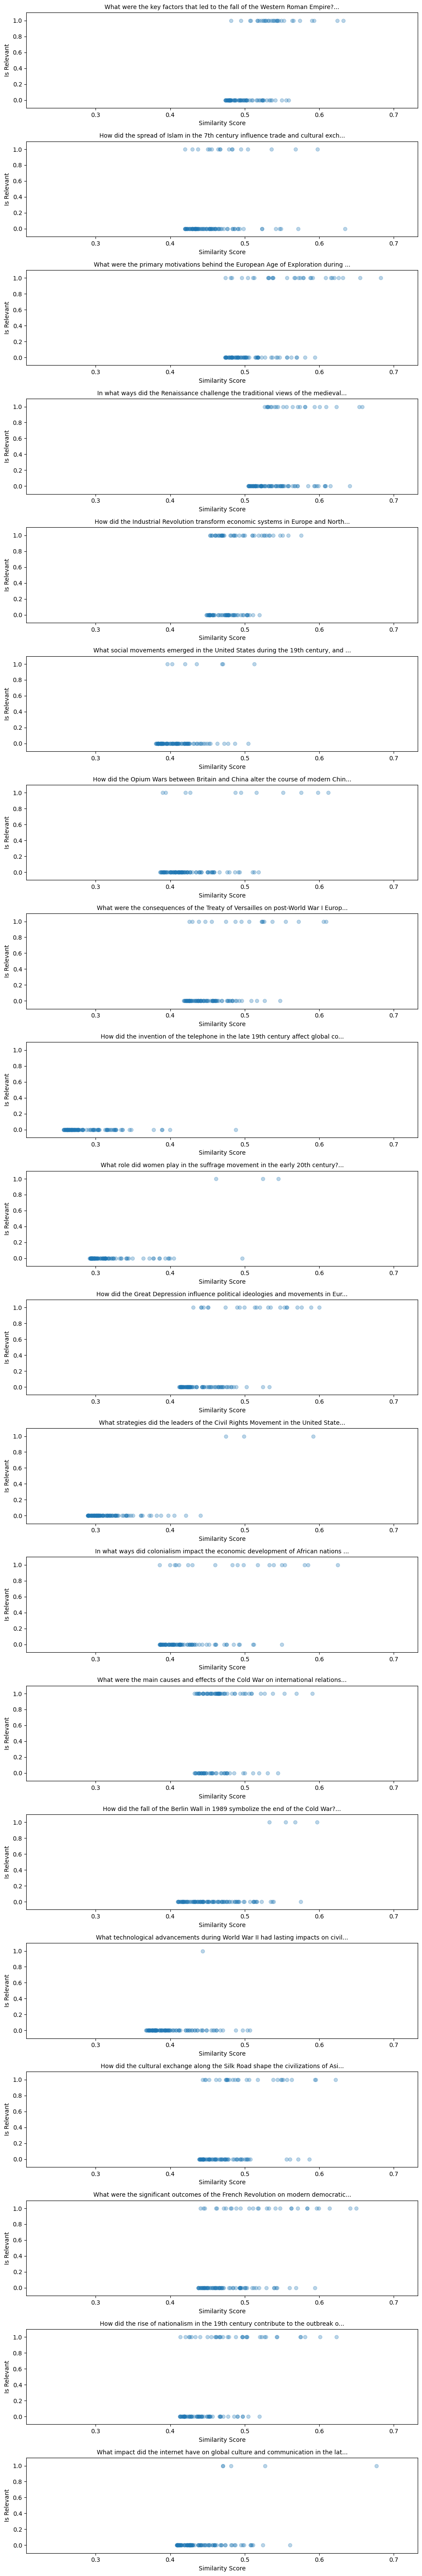

In [96]:
queries = df_with_evals['query'].unique()
fig, axes = plt.subplots(len(queries), 1, figsize=(10, 3*len(queries)))

if len(queries) == 1:
    axes = [axes]  # Ensure axes is iterable for single query

for i, query in enumerate(queries):
    df_query = df_with_evals[df_with_evals['query'] == query]
    axes[i].scatter(df_query['score'], df_query['is_relevant'].astype(int), alpha=0.3)
    axes[i].set_xlabel('Similarity Score')
    axes[i].set_ylabel('Is Relevant')
    axes[i].set_title(f'{query[:80]}...', fontsize=10)
    axes[i].set_ylim(-0.1, 1.1)
    axes[i].set_xlim(score_min - 0.05, score_max + 0.05)

plt.tight_layout()
plt.show()

#### Metrics vs score cutoff

Calculate metrics as a function of score cutoff:

Metrics:
- recall: as a fraction of all 'Relevant' results, how many are retrieved
- precision: as a fcation of all results above cutoff, how many are 'Relavant'
- count: how many results retrieved above cutoff
- per query basis: calculate the above, but calculate individually for each query and plot the distribution

In [54]:
def calculate_metrics_by_cutoff(df, score_cutoffs=None):
    """Calculate precision, recall, and count for different score cutoffs"""
    if score_cutoffs is None:
        # Create cutoffs from min to max score
        score_cutoffs = np.linspace(df['score'].min(), df['score'].max(), 50)
    
    metrics = []
    
    for cutoff in score_cutoffs:
        # Filter results above cutoff
        above_cutoff = df[df['score'] >= cutoff]
        
        # Calculate metrics
        total_relevant = len(df[df['is_relevant'] == True])
        retrieved_relevant = len(above_cutoff[above_cutoff['is_relevant'] == True])
        total_retrieved = len(above_cutoff)
        
        # Avoid division by zero
        recall = retrieved_relevant / total_relevant if total_relevant > 0 else 0
        precision = retrieved_relevant / total_retrieved if total_retrieved > 0 else 0
        
        metrics.append({
            'cutoff': cutoff,
            'precision': precision,
            'recall': recall,
            'count': total_retrieved,
            'relevant_count': retrieved_relevant
        })
    
    return pd.DataFrame(metrics)


In [55]:

def calculate_metrics_per_query(df, score_cutoffs=None):
    """Calculate metrics per query for different score cutoffs"""
    if score_cutoffs is None:
        score_cutoffs = np.linspace(df['score'].min(), df['score'].max(), 20)
    
    per_query_metrics = []
    
    for query in df['query'].unique():
        query_df = df[df['query'] == query]
        
        for cutoff in score_cutoffs:
            above_cutoff = query_df[query_df['score'] >= cutoff]
            
            total_relevant = len(query_df[query_df['is_relevant'] == True])
            retrieved_relevant = len(above_cutoff[above_cutoff['is_relevant'] == True])
            total_retrieved = len(above_cutoff)
            
            recall = retrieved_relevant / total_relevant if total_relevant > 0 else 0
            precision = retrieved_relevant / total_retrieved if total_retrieved > 0 else 0
            
            per_query_metrics.append({
                'query': query,
                'cutoff': cutoff,
                'precision': precision,
                'recall': recall,
                'count': total_retrieved,
                'relevant_count': retrieved_relevant,
                'total_relevant_for_query': total_relevant
            })
    
    return pd.DataFrame(per_query_metrics)


In [56]:

# Calculate overall metrics
overall_metrics = calculate_metrics_by_cutoff(df_with_evals)
per_query_metrics = calculate_metrics_per_query(df_with_evals)


In [85]:
# add f1 score to overall_metrics
overall_metrics['f1'] = 2 * (overall_metrics['precision'] * overall_metrics['recall']) / (overall_metrics['precision'] + overall_metrics['recall'] + 1e-10)  # small epsilon to avoid div by zero
per_query_metrics['f1'] = 2 * (per_query_metrics['precision'] * per_query_metrics['recall']) / (per_query_metrics['precision'] + per_query_metrics['recall'] + 1e-10)

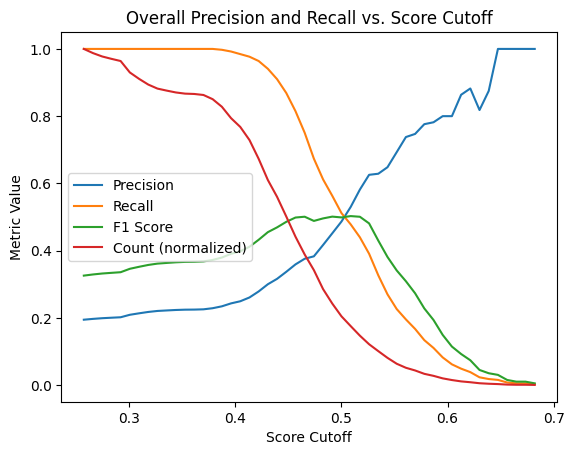

In [63]:
plt.plot(overall_metrics['cutoff'], overall_metrics['precision'], label='Precision')
plt.plot(overall_metrics['cutoff'], overall_metrics['recall'], label='Recall')
plt.plot(overall_metrics['cutoff'], overall_metrics['f1'], label='F1 Score')
plt.plot(overall_metrics['cutoff'], overall_metrics['count']/2000, label='Count (normalized)')
plt.xlabel('Score Cutoff')
plt.ylabel('Metric Value')
plt.title('Overall Precision and Recall vs. Score Cutoff')
plt.legend()
plt.show()

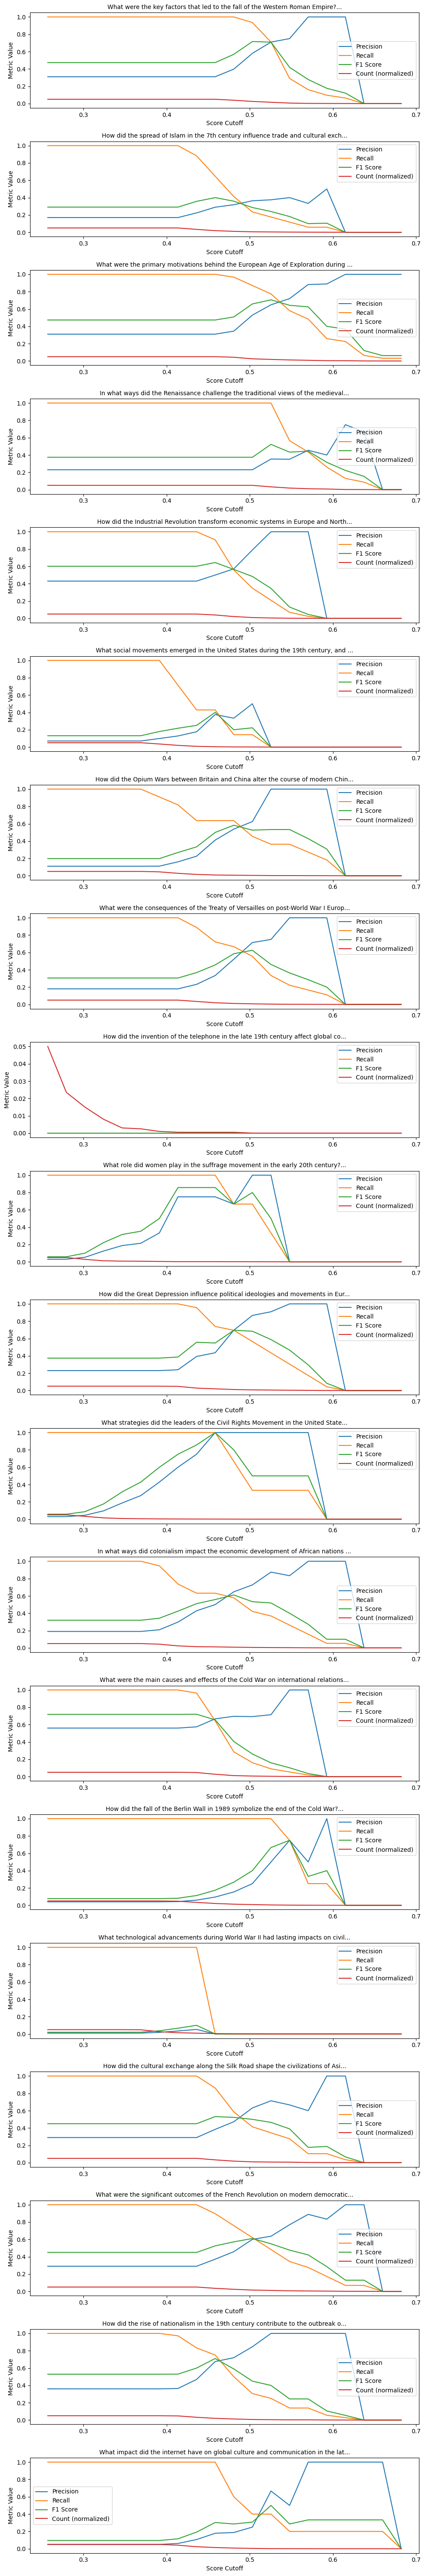

In [206]:
queries = per_query_metrics['query'].unique()
fig, axes = plt.subplots(len(queries), 1, figsize=(10, 3*len(queries)))

if len(queries) == 1:
    axes = [axes]  # Ensure axes is iterable for single query

for i, query in enumerate(queries):
    df_query = per_query_metrics[per_query_metrics['query'] == query]
    axes[i].plot(df_query['cutoff'], df_query['precision'], label='Precision')
    axes[i].plot(df_query['cutoff'], df_query['recall'], label='Recall')
    axes[i].plot(df_query['cutoff'], df_query['f1'], label='F1 Score')
    axes[i].plot(df_query['cutoff'], df_query['count']/2000, label='Count (normalized)')
    axes[i].set_xlabel('Score Cutoff')
    axes[i].set_ylabel('Metric Value')
    axes[i].set_title(f'{query[:80]}...', fontsize=10)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [81]:
per_query_metrics.groupby('query').agg({
    'total_relevant_for_query': 'max',
}).sort_values('total_relevant_for_query', ascending=False)

,total_relevant_for_query
query,
What were the main causes and effects of the Cold War on international relations?,56
How did the Industrial Revolution transform economic systems in Europe and North America?,43
How did the rise of nationalism in the 19th century contribute to the outbreak of World War I?,36
What were the primary motivations behind the European Age of Exploration during the 15th and 16th centuries?,31
What were the key factors that led to the fall of the Western Roman Empire?,31
What were the significant outcomes of the French Revolution on modern democratic principles?,29
How did the cultural exchange along the Silk Road shape the civilizations of Asia and Europe?,29
In what ways did the Renaissance challenge the traditional views of the medieval Church?,23
How did the Great Depression influence political ideologies and movements in Europe?,23


In [83]:
top_count_query = "What were the main causes and effects of the Cold War on international relations?"
df_with_evals[df_with_evals['query'] == top_count_query]

,query,text,score,is_relevant,reasoning
1300,What were the main causes and effects of the C...,The Cold War (as it came to be called) had beg...,0.590601,True,"The paragraph discusses the Cold War, its ideo..."
1301,What were the main causes and effects of the C...,"More directly, this affected the international...",0.569078,True,The paragraph discusses the ideological underp...
1302,What were the main causes and effects of the C...,The other novelty was the Cold War. In the imm...,0.553009,True,"The paragraph discusses the Cold War, specific..."
1303,What were the main causes and effects of the C...,"Piecemeal, relations between the two major wor...",0.544692,False,The paragraph discusses the aftermath of World...
1304,What were the main causes and effects of the C...,"In one sense, after all, the Cold War was a la...",0.537874,True,The paragraph discusses the ideological and di...
...,...,...,...,...,...
1395,What were the main causes and effects of the C...,There was to be no world recovery before anoth...,0.434425,False,The paragraph discusses economic conditions an...
1396,What were the main causes and effects of the C...,More was involved in domestic strife over Viet...,0.434283,False,The paragraph discusses domestic strife in the...
1397,What were the main causes and effects of the C...,An almost immediate consequence was an upheava...,0.432951,False,The paragraph discusses the May 4th Movement i...
1398,What were the main causes and effects of the C...,It is usually conceded that one of the superio...,0.432793,False,The paragraph discusses Thucydides and the Pel...


In [87]:
per_query_metrics[per_query_metrics['query'] == top_count_query]

,query,cutoff,precision,recall,count,relevant_count,total_relevant_for_query,f1
260,What were the main causes and effects of the C...,0.257160,0.560000,1.000000,100,56,56,0.717949
261,What were the main causes and effects of the C...,0.279530,0.560000,1.000000,100,56,56,0.717949
262,What were the main causes and effects of the C...,0.301899,0.560000,1.000000,100,56,56,0.717949
263,What were the main causes and effects of the C...,0.324269,0.560000,1.000000,100,56,56,0.717949
264,What were the main causes and effects of the C...,0.346638,0.560000,1.000000,100,56,56,0.717949
265,What were the main causes and effects of the C...,0.369007,0.560000,1.000000,100,56,56,0.717949
266,What were the main causes and effects of the C...,0.391377,0.560000,1.000000,100,56,56,0.717949
267,What were the main causes and effects of the C...,0.413746,0.560000,1.000000,100,56,56,0.717949
268,What were the main causes and effects of the C...,0.436116,0.574468,0.964286,94,54,56,0.720000
269,What were the main causes and effects of the C...,0.458485,0.666667,0.642857,54,36,56,0.654545


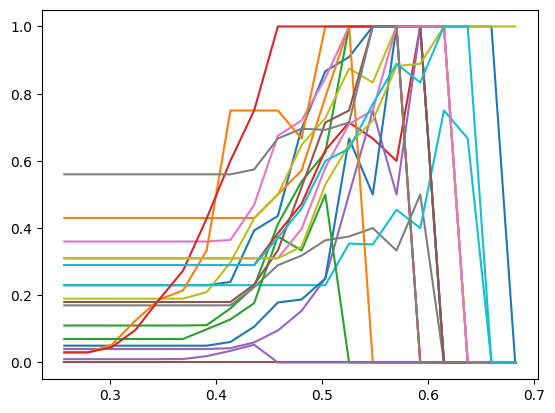

In [97]:
for query, df in per_query_metrics.groupby('query'):
    # print(df)
    # plt.plot(df['cutoff'], df['precision'], label='Precision')
    # plt.plot(df['cutoff'], df['recall'], label='Recall')
    plt.plot(df['cutoff'], df['f1'], label='F1 Score')
    # plt.plot(df['cutoff'], df['count']/100, label='Count (normalized)')

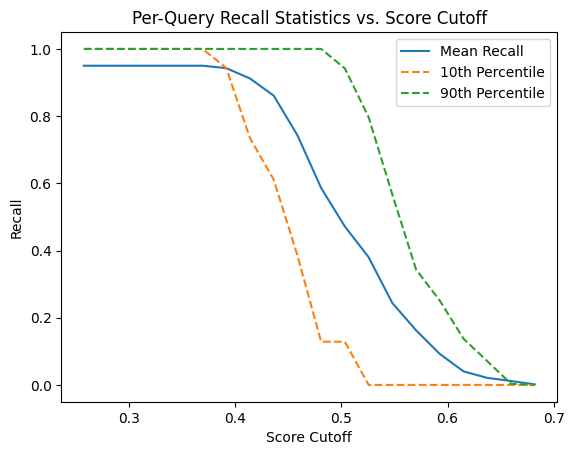

In [211]:
per_query_stats_recall = per_query_metrics.groupby('cutoff')['recall'].describe(percentiles=[0.10, 0.5, 0.90])
plt.plot(per_query_stats_recall.index, per_query_stats_recall['mean'], label='Mean Recall')
plt.plot(per_query_stats_recall.index, per_query_stats_recall['10%'], label='10th Percentile', linestyle='--')
plt.plot(per_query_stats_recall.index, per_query_stats_recall['90%'], label='90th Percentile', linestyle='--')
plt.xlabel('Score Cutoff')
plt.ylabel('Recall')
plt.title('Per-Query Recall Statistics vs. Score Cutoff')
plt.legend()
plt.show()

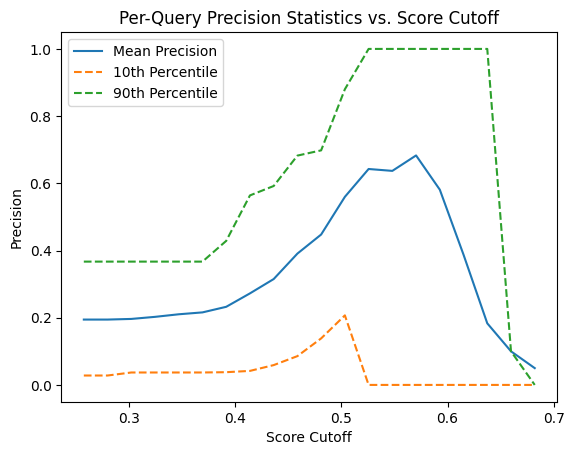

In [212]:
per_query_stats_precision = per_query_metrics.groupby('cutoff')['precision'].describe(percentiles=[0.10, 0.5, 0.90])
plt.plot(per_query_stats_precision.index, per_query_stats_precision['mean'], label='Mean Precision')
plt.plot(per_query_stats_precision.index, per_query_stats_precision['10%'], label='10th Percentile', linestyle='--')
plt.plot(per_query_stats_precision.index, per_query_stats_precision['90%'], label='90th Percentile', linestyle='--')
plt.xlabel('Score Cutoff')
plt.ylabel('Precision')
plt.title('Per-Query Precision Statistics vs. Score Cutoff')
plt.legend()
plt.show()

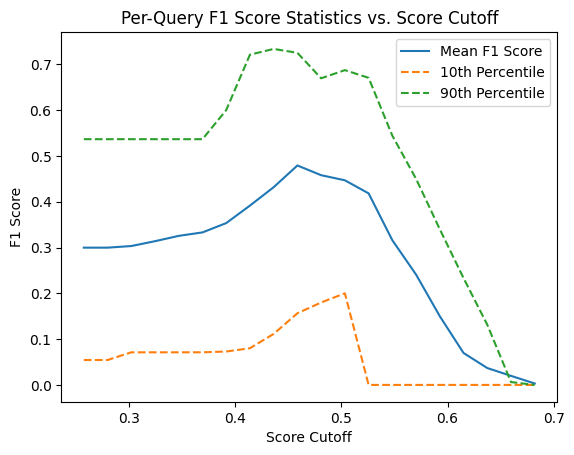

In [210]:
per_query_stats_f1 = per_query_metrics.groupby('cutoff')['f1'].describe(percentiles=[0.10, 0.5, 0.90])
plt.plot(per_query_stats_f1.index, per_query_stats_f1['mean'], label='Mean F1 Score')
plt.plot(per_query_stats_f1.index, per_query_stats_f1['10%'], label='10th Percentile', linestyle='--')
plt.plot(per_query_stats_f1.index, per_query_stats_f1['90%'], label='90th Percentile', linestyle='--')
plt.xlabel('Score Cutoff')
plt.ylabel('F1 Score')
plt.title('Per-Query F1 Score Statistics vs. Score Cutoff')
plt.legend()
plt.show()

#### Metrics vs score cutoff

Calculate metrics as a function of result #:

Metrics: same as above, but vs 'k' instead of score cutoff

In [ ]:
def calculate_metrics_by_cutoff(df, score_cutoffs=None):
    """Calculate precision, recall, and count for different score cutoffs"""
    if score_cutoffs is None:
        # Create cutoffs from min to max score
        score_cutoffs = np.linspace(df['score'].min(), df['score'].max(), 50)
    
    metrics = []
    
    for cutoff in score_cutoffs:
        # Filter results above cutoff
        above_cutoff = df[df['score'] >= cutoff]
        
        # Calculate metrics
        total_relevant = len(df[df['is_relevant'] == True])
        retrieved_relevant = len(above_cutoff[above_cutoff['is_relevant'] == True])
        total_retrieved = len(above_cutoff)
        
        # Avoid division by zero
        recall = retrieved_relevant / total_relevant if total_relevant > 0 else 0
        precision = retrieved_relevant / total_retrieved if total_retrieved > 0 else 0
        
        metrics.append({
            'cutoff': cutoff,
            'precision': precision,
            'recall': recall,
            'count': total_retrieved,
            'relevant_count': retrieved_relevant
        })
    
    return pd.DataFrame(metrics)


In [ ]:

def calculate_metrics_per_query(df, score_cutoffs=None):
    """Calculate metrics per query for different score cutoffs"""
    if score_cutoffs is None:
        score_cutoffs = np.linspace(df['score'].min(), df['score'].max(), 20)
    
    per_query_metrics = []
    
    for query in df['query'].unique():
        query_df = df[df['query'] == query]
        
        for cutoff in score_cutoffs:
            above_cutoff = query_df[query_df['score'] >= cutoff]
            
            total_relevant = len(query_df[query_df['is_relevant'] == True])
            retrieved_relevant = len(above_cutoff[above_cutoff['is_relevant'] == True])
            total_retrieved = len(above_cutoff)
            
            recall = retrieved_relevant / total_relevant if total_relevant > 0 else 0
            precision = retrieved_relevant / total_retrieved if total_retrieved > 0 else 0
            
            per_query_metrics.append({
                'query': query,
                'cutoff': cutoff,
                'precision': precision,
                'recall': recall,
                'count': total_retrieved,
                'relevant_count': retrieved_relevant,
                'total_relevant_for_query': total_relevant
            })
    
    return pd.DataFrame(per_query_metrics)


In [ ]:

# Calculate overall metrics
overall_metrics = calculate_metrics_by_cutoff(df_with_evals)
per_query_metrics = calculate_metrics_per_query(df_with_evals)


In [ ]:
# add f1 score to overall_metrics
overall_metrics['f1'] = 2 * (overall_metrics['precision'] * overall_metrics['recall']) / (overall_metrics['precision'] + overall_metrics['recall'] + 1e-10)  # small epsilon to avoid div by zero
per_query_metrics['f1'] = 2 * (per_query_metrics['precision'] * per_query_metrics['recall']) / (per_query_metrics['precision'] + per_query_metrics['recall'] + 1e-10)

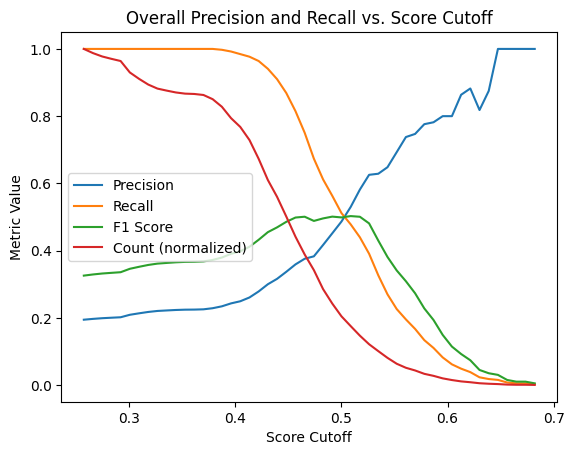

In [ ]:
plt.plot(overall_metrics['cutoff'], overall_metrics['precision'], label='Precision')
plt.plot(overall_metrics['cutoff'], overall_metrics['recall'], label='Recall')
plt.plot(overall_metrics['cutoff'], overall_metrics['f1'], label='F1 Score')
plt.plot(overall_metrics['cutoff'], overall_metrics['count']/2000, label='Count (normalized)')
plt.xlabel('Score Cutoff')
plt.ylabel('Metric Value')
plt.title('Overall Precision and Recall vs. Score Cutoff')
plt.legend()
plt.show()

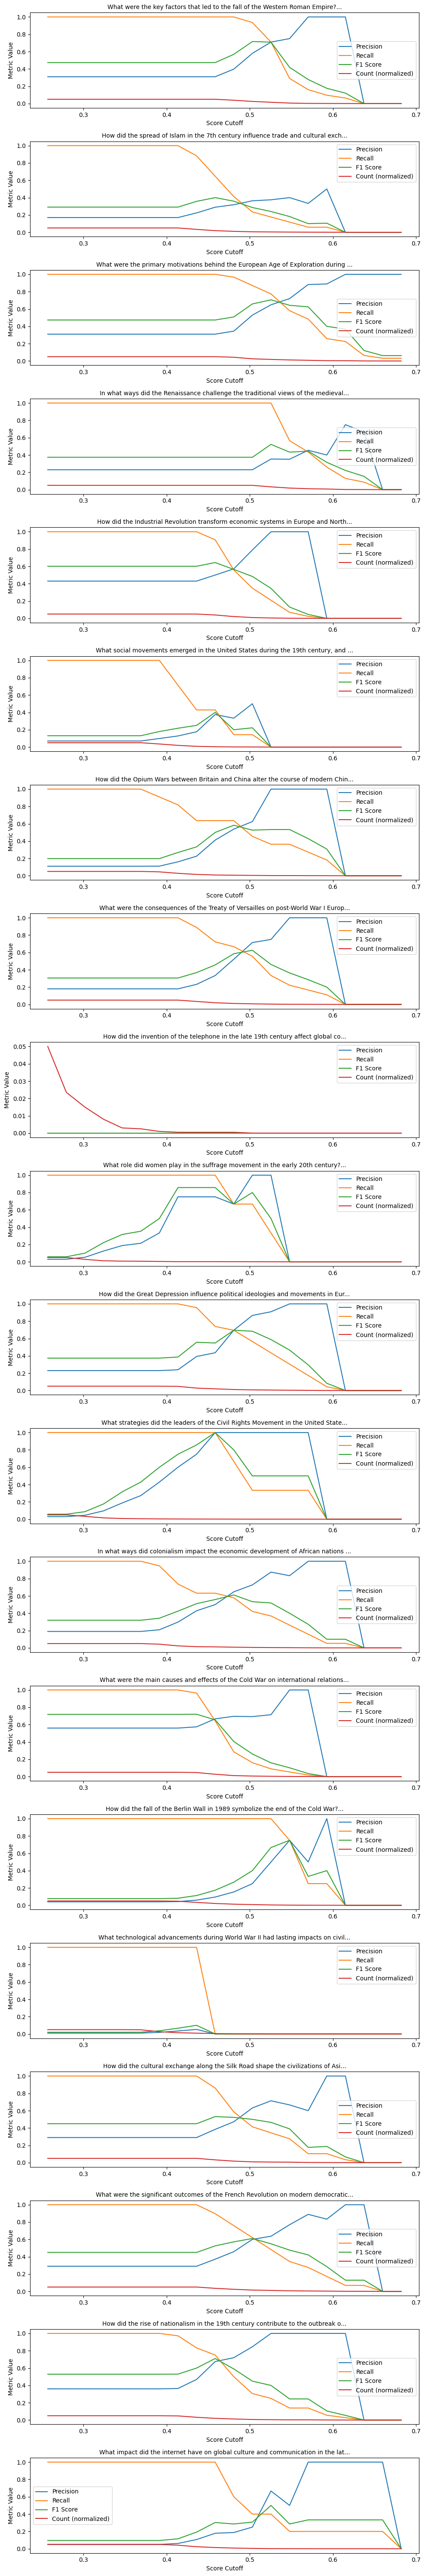

In [ ]:
queries = per_query_metrics['query'].unique()
fig, axes = plt.subplots(len(queries), 1, figsize=(10, 3*len(queries)))

if len(queries) == 1:
    axes = [axes]  # Ensure axes is iterable for single query

for i, query in enumerate(queries):
    df_query = per_query_metrics[per_query_metrics['query'] == query]
    axes[i].plot(df_query['cutoff'], df_query['precision'], label='Precision')
    axes[i].plot(df_query['cutoff'], df_query['recall'], label='Recall')
    axes[i].plot(df_query['cutoff'], df_query['f1'], label='F1 Score')
    axes[i].plot(df_query['cutoff'], df_query['count']/2000, label='Count (normalized)')
    axes[i].set_xlabel('Score Cutoff')
    axes[i].set_ylabel('Metric Value')
    axes[i].set_title(f'{query[:80]}...', fontsize=10)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
per_query_metrics.groupby('query').agg({
    'total_relevant_for_query': 'max',
}).sort_values('total_relevant_for_query', ascending=False)

,total_relevant_for_query
query,
What were the main causes and effects of the Cold War on international relations?,56
How did the Industrial Revolution transform economic systems in Europe and North America?,43
How did the rise of nationalism in the 19th century contribute to the outbreak of World War I?,36
What were the primary motivations behind the European Age of Exploration during the 15th and 16th centuries?,31
What were the key factors that led to the fall of the Western Roman Empire?,31
What were the significant outcomes of the French Revolution on modern democratic principles?,29
How did the cultural exchange along the Silk Road shape the civilizations of Asia and Europe?,29
In what ways did the Renaissance challenge the traditional views of the medieval Church?,23
How did the Great Depression influence political ideologies and movements in Europe?,23


In [ ]:
top_count_query = "What were the main causes and effects of the Cold War on international relations?"
df_with_evals[df_with_evals['query'] == top_count_query]

,query,text,score,is_relevant,reasoning
1300,What were the main causes and effects of the C...,The Cold War (as it came to be called) had beg...,0.590601,True,"The paragraph discusses the Cold War, its ideo..."
1301,What were the main causes and effects of the C...,"More directly, this affected the international...",0.569078,True,The paragraph discusses the ideological underp...
1302,What were the main causes and effects of the C...,The other novelty was the Cold War. In the imm...,0.553009,True,"The paragraph discusses the Cold War, specific..."
1303,What were the main causes and effects of the C...,"Piecemeal, relations between the two major wor...",0.544692,False,The paragraph discusses the aftermath of World...
1304,What were the main causes and effects of the C...,"In one sense, after all, the Cold War was a la...",0.537874,True,The paragraph discusses the ideological and di...
...,...,...,...,...,...
1395,What were the main causes and effects of the C...,There was to be no world recovery before anoth...,0.434425,False,The paragraph discusses economic conditions an...
1396,What were the main causes and effects of the C...,More was involved in domestic strife over Viet...,0.434283,False,The paragraph discusses domestic strife in the...
1397,What were the main causes and effects of the C...,An almost immediate consequence was an upheava...,0.432951,False,The paragraph discusses the May 4th Movement i...
1398,What were the main causes and effects of the C...,It is usually conceded that one of the superio...,0.432793,False,The paragraph discusses Thucydides and the Pel...


In [ ]:
per_query_metrics[per_query_metrics['query'] == top_count_query]

,query,cutoff,precision,recall,count,relevant_count,total_relevant_for_query,f1
260,What were the main causes and effects of the C...,0.257160,0.560000,1.000000,100,56,56,0.717949
261,What were the main causes and effects of the C...,0.279530,0.560000,1.000000,100,56,56,0.717949
262,What were the main causes and effects of the C...,0.301899,0.560000,1.000000,100,56,56,0.717949
263,What were the main causes and effects of the C...,0.324269,0.560000,1.000000,100,56,56,0.717949
264,What were the main causes and effects of the C...,0.346638,0.560000,1.000000,100,56,56,0.717949
265,What were the main causes and effects of the C...,0.369007,0.560000,1.000000,100,56,56,0.717949
266,What were the main causes and effects of the C...,0.391377,0.560000,1.000000,100,56,56,0.717949
267,What were the main causes and effects of the C...,0.413746,0.560000,1.000000,100,56,56,0.717949
268,What were the main causes and effects of the C...,0.436116,0.574468,0.964286,94,54,56,0.720000
269,What were the main causes and effects of the C...,0.458485,0.666667,0.642857,54,36,56,0.654545


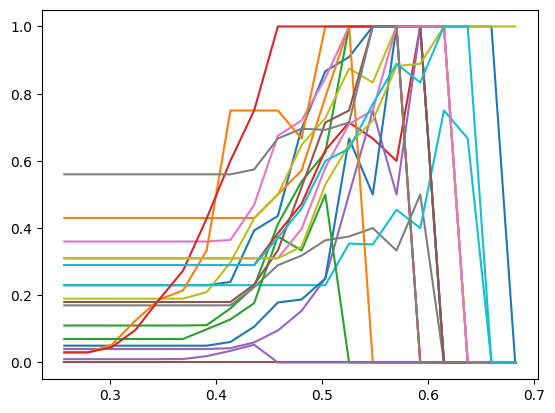

In [ ]:
for query, df in per_query_metrics.groupby('query'):
    # print(df)
    # plt.plot(df['cutoff'], df['precision'], label='Precision')
    # plt.plot(df['cutoff'], df['recall'], label='Recall')
    plt.plot(df['cutoff'], df['f1'], label='F1 Score')
    # plt.plot(df['cutoff'], df['count']/100, label='Count (normalized)')

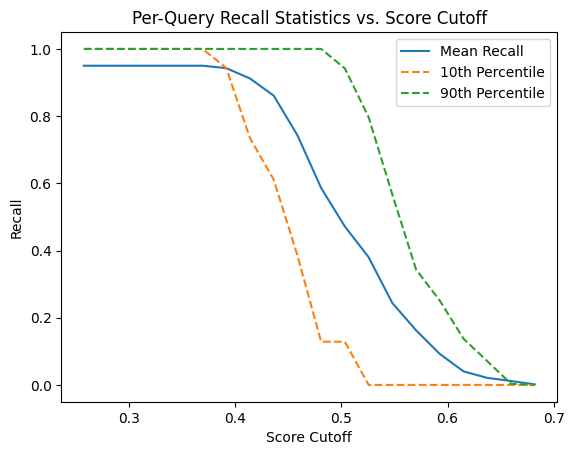

In [ ]:
per_query_stats_recall = per_query_metrics.groupby('cutoff')['recall'].describe(percentiles=[0.10, 0.5, 0.90])
plt.plot(per_query_stats_recall.index, per_query_stats_recall['mean'], label='Mean Recall')
plt.plot(per_query_stats_recall.index, per_query_stats_recall['10%'], label='10th Percentile', linestyle='--')
plt.plot(per_query_stats_recall.index, per_query_stats_recall['90%'], label='90th Percentile', linestyle='--')
plt.xlabel('Score Cutoff')
plt.ylabel('Recall')
plt.title('Per-Query Recall Statistics vs. Score Cutoff')
plt.legend()
plt.show()

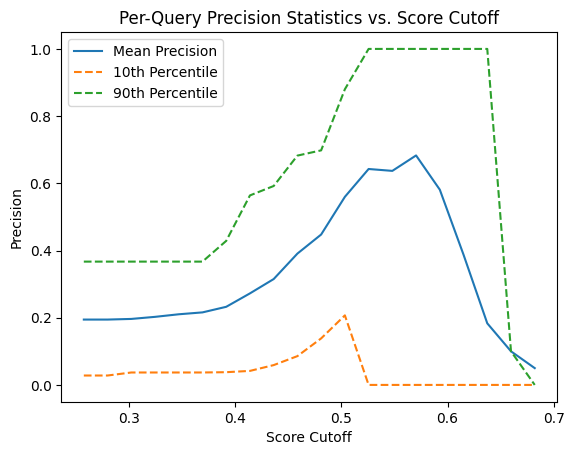

In [ ]:
per_query_stats_precision = per_query_metrics.groupby('cutoff')['precision'].describe(percentiles=[0.10, 0.5, 0.90])
plt.plot(per_query_stats_precision.index, per_query_stats_precision['mean'], label='Mean Precision')
plt.plot(per_query_stats_precision.index, per_query_stats_precision['10%'], label='10th Percentile', linestyle='--')
plt.plot(per_query_stats_precision.index, per_query_stats_precision['90%'], label='90th Percentile', linestyle='--')
plt.xlabel('Score Cutoff')
plt.ylabel('Precision')
plt.title('Per-Query Precision Statistics vs. Score Cutoff')
plt.legend()
plt.show()

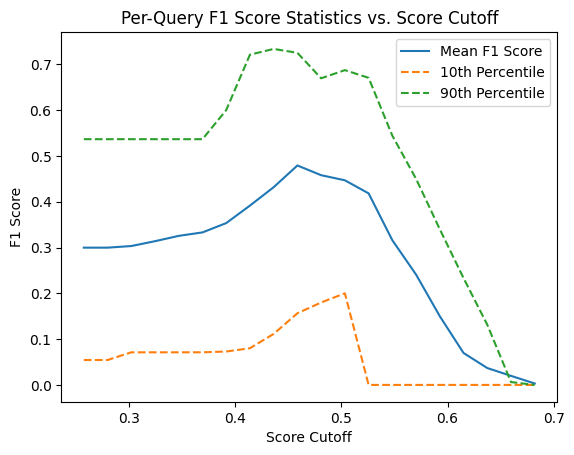

In [ ]:
per_query_stats_f1 = per_query_metrics.groupby('cutoff')['f1'].describe(percentiles=[0.10, 0.5, 0.90])
plt.plot(per_query_stats_f1.index, per_query_stats_f1['mean'], label='Mean F1 Score')
plt.plot(per_query_stats_f1.index, per_query_stats_f1['10%'], label='10th Percentile', linestyle='--')
plt.plot(per_query_stats_f1.index, per_query_stats_f1['90%'], label='90th Percentile', linestyle='--')
plt.xlabel('Score Cutoff')
plt.ylabel('F1 Score')
plt.title('Per-Query F1 Score Statistics vs. Score Cutoff')
plt.legend()
plt.show()